##### Copyright 2020 The TensorFlow IO Authors.

In [9]:
from flask import Flask, Response
from kafka3 import KafkaConsumer
from collections import Counter
import math
import os
import sys
sys.path.append('../../../real-time-baby-sleep-position-detector')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'
# tf.get_logger().setLevel('ERROR')
from utils.settings import PROCESSED_EVENTS_TOPIC
from utils.data_utils import create_consumer
import json

In [2]:
consumer = create_consumer(topic=PROCESSED_EVENTS_TOPIC)

In [18]:
message = consumer.poll(timeout_ms=50000)

In [22]:
json.loads(list(message.items())[0][1][0].value.decode('utf-8'))


{'status': 'back', 'timestamp': '2023-07-10 17:31:09'}

In [16]:
payload = json.loads(list(message.items())[0][1][0].value.decode('utf-8'))
for k in payload.keys():
    if k == 'status':
        status = payload['status']
        baby_activity.append(status)
        baby_activity = trim_activity(baby_activity)
        entropy = calculate_entropy(baby_activity)
        last_status = update_last_status(last_status, status)
    elif k == 'timestamp':
        timestamp = payload['timestamp']


back
2023-07-10 17:21:22


In [32]:
from collections import Counter
import math

status = ['ok', 'ok', 'ok', 'yes', 'ok', 'no', 'ok', 'ok', 'ok', 'ok', 'ok', 'round', 'ok', 'ok', 'ok', 'ok', 'no', 'no', 'no', 'no', 'no', 'no']

status_counts = Counter(status)

total_count = len(status)
entropy = 0.0

for count in status_counts.values():
    print(count)
    probability = count / total_count
    entropy -= probability * math.log2(probability)

print("Shannon Entropy:", entropy)


13
1
7
1
Shannon Entropy: 1.379558855444687


In [27]:
import numpy as np
import pandas as pd
from collections import Counter


status = ['ok','ok','ok','yes','ok','no','ok','ok','ok','ok','ok','round','ok','ok','ok','ok', 'no','no','no','no','no','no']

status.append('no')

# status level
status_counts = Counter(status[-5:])

total_count = len(status[-5:])
no_count = status_counts['no']
no_ratio = no_count / total_count

# remove level
status = status[5:]

print("Total Count:", total_count)
print("No Count:", no_count)
print("No Ratio:", no_ratio)



Total Count: 5
No Count: 5
No Ratio: 1.0


In [18]:
status[-5:]

['no', 'no', 'no', 'no', 'test']

In [1]:
import numpy as np
from math import atan2, sqrt, pi

# Sensor data (accelerometer, gyroscope, and magnetometer readings)
accel_data = np.array([0.1, 0.2, 9.7])  # Accelerometer data (m/s^2)
gyro_data = np.array([0.01, 0.02, 0.03])  # Gyroscope data (rad/s)
mag_data = np.array([50, -20, 30])  # Magnetometer data (microtesla)

# Constants for sensor fusion
beta = 0.98  # Gyroscope drift compensation factor

# Initial joint angle and target joint angle
joint_angle = 0.0  # radians
target_angle = np.pi/2  # radians

# Duration and time step
duration = 1.0  # seconds
dt = 0.01  # seconds
num_iterations = int(duration / dt)

def update_pose(accel, gyro, mag, dt):
    global joint_angle  # Declare joint_angle as a global variable
    
    # Convert sensor data to numpy arrays
    accel = np.array(accel, dtype=np.float64)
    gyro = np.array(gyro, dtype=np.float64)
    mag = np.array(mag, dtype=np.float64)
    
    # Normalize accelerometer data
    accel /= np.linalg.norm(accel)
    
    # Normalize magnetometer data
    mag /= np.linalg.norm(mag)
    
    # Calculate pitch and roll angles from accelerometer data
    pitch = atan2(accel[1], sqrt(accel[0]**2 + accel[2]**2))
    roll = atan2(-accel[0], accel[2])
    
    # Calculate yaw angle from magnetometer data
    mag_yaw = atan2(mag[1]*np.sin(roll) - mag[2]*np.cos(roll), mag[0]*np.cos(pitch) + mag[1]*np.sin(pitch)*np.sin(roll) + mag[2]*np.sin(pitch)*np.cos(roll))
    
    # Update joint angle based on gyroscope data
    joint_angle += gyro[1] * dt
    
    # Fuse gyroscope and magnetometer data to compensate for gyroscope drift
    fused_angle = beta * joint_angle + (1 - beta) * mag_yaw
    
    return fused_angle

# Main loop
for i in range(num_iterations):
    # Calculate the interpolation factor (0 to 1) based on time
    t = i * dt / duration
    
    # Interpolate the target joint angle from point A to point B
    interpolated_angle = (1 - t) * joint_angle + t * target_angle
    
    # Set the target joint angle for the next iteration
    target_angle = interpolated_angle
    
    # Call update_pose function to update the body pose
    joint_angle = update_pose(accel_data, gyro_data, mag_data, dt)
    
    # Print the joint angle representing the body pose
    print("Joint Angle: ", joint_angle)


Joint Angle:  -0.010444491287080578
Joint Angle:  -0.020680092748419546
Joint Angle:  -0.030710982180531733
Joint Angle:  -0.04054125382400168
Joint Angle:  -0.05017492003460222
Joint Angle:  -0.059615912920990756
Joint Angle:  -0.06886808594965152
Joint Angle:  -0.07793521551773906
Joint Angle:  -0.08682100249446485
Joint Angle:  -0.09552907373165613
Joint Angle:  -0.10406298354410358
Joint Angle:  -0.11242621516030209
Joint Angle:  -0.12062218214417662
Joint Angle:  -0.12865422978837365
Joint Angle:  -0.13652563647968677
Joint Angle:  -0.1442396150371736
Joint Angle:  -0.1517993140235107
Joint Angle:  -0.15920781903012107
Joint Angle:  -0.16646815393659922
Joint Angle:  -0.1735832821449478
Joint Angle:  -0.18055610778912942
Joint Angle:  -0.1873894769204274
Joint Angle:  -0.19408617866909944
Joint Angle:  -0.20064894638279804
Joint Angle:  -0.20708045874222264
Joint Angle:  -0.21338334085445876
Joint Angle:  -0.21956016532445016
Joint Angle:  -0.22561345330504173
Joint Angle:  -0.231

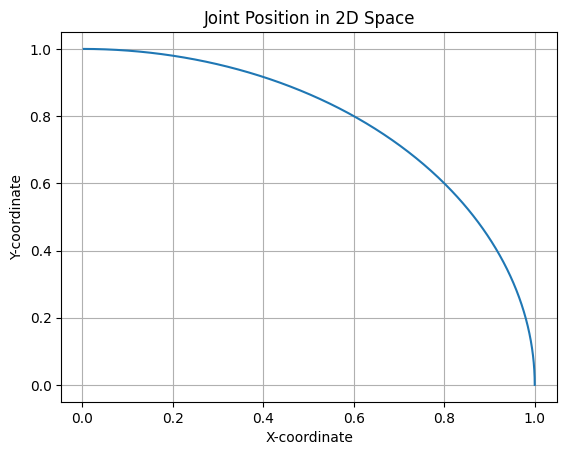

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Joint angle range
start_angle = 0.0
end_angle = np.pi/2

# Arm length
arm_length = 1.0

# Duration and time step
duration = 5.0
dt = 0.01
num_steps = int(duration / dt)

# Lists to store joint position coordinates
x_coordinates = []
y_coordinates = []

# Calculate joint position over time
for i in range(num_steps):
    # Calculate the interpolation factor (0 to 1) based on time
    t = i / num_steps

    # Interpolate the joint angle from start_angle to end_angle
    joint_angle = (1 - t) * start_angle + t * end_angle

    # Calculate the x and y coordinates of the joint based on the joint angle and arm length
    x = arm_length * np.cos(joint_angle)
    y = arm_length * np.sin(joint_angle)

    # Append the coordinates to the lists
    x_coordinates.append(x)
    y_coordinates.append(y)

# Generate a graph of the joint position
plt.plot(x_coordinates, y_coordinates)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Joint Position in 2D Space')
plt.grid(True)
plt.show()


Joint Angle:  -0.010444491287080578
Joint Angle:  -0.020680092748419546
Joint Angle:  -0.030710982180531733
Joint Angle:  -0.04054125382400168
Joint Angle:  -0.05017492003460222
Joint Angle:  -0.059615912920990756
Joint Angle:  -0.06886808594965152
Joint Angle:  -0.07793521551773906
Joint Angle:  -0.08682100249446485
Joint Angle:  -0.09552907373165613
Joint Angle:  -0.10406298354410358
Joint Angle:  -0.11242621516030209
Joint Angle:  -0.12062218214417662
Joint Angle:  -0.12865422978837365
Joint Angle:  -0.13652563647968677
Joint Angle:  -0.1442396150371736
Joint Angle:  -0.1517993140235107
Joint Angle:  -0.15920781903012107
Joint Angle:  -0.16646815393659922
Joint Angle:  -0.1735832821449478
Joint Angle:  -0.18055610778912942
Joint Angle:  -0.1873894769204274
Joint Angle:  -0.19408617866909944
Joint Angle:  -0.20064894638279804
Joint Angle:  -0.20708045874222264
Joint Angle:  -0.21338334085445876
Joint Angle:  -0.21956016532445016
Joint Angle:  -0.22561345330504173
Joint Angle:  -0.231

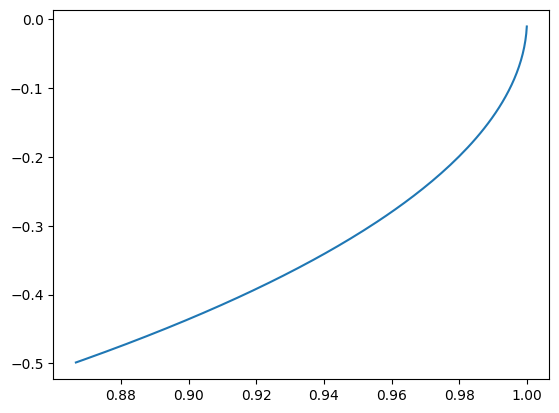

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, pi, atan2, sqrt

# Sensor data (accelerometer, gyroscope, and magnetometer readings)
accel_data = np.array([0.1, 0.2, 9.7])  # Accelerometer data (m/s^2)
gyro_data = np.array([0.01, 0.02, 0.03])  # Gyroscope data (rad/s)
mag_data = np.array([50, -20, 30])  # Magnetometer data (microtesla)

# Constants for sensor fusion
beta = 0.98  # Gyroscope drift compensation factor

# Initial joint angle and target joint angle
joint_angle = 0.0  # radians
target_angle = np.pi/2  # radians

# Duration and time step
duration = 5.0  # seconds
dt = 0.01  # seconds
num_iterations = int(duration / dt)

def update_pose(accel, gyro, mag, dt):
    global joint_angle  # Declare joint_angle as a global variable
    
    # Convert sensor data to numpy arrays
    accel = np.array(accel, dtype=np.float64)
    gyro = np.array(gyro, dtype=np.float64)
    mag = np.array(mag, dtype=np.float64)
    
    # Normalize accelerometer data
    accel /= np.linalg.norm(accel)
    
    # Normalize magnetometer data
    mag /= np.linalg.norm(mag)
    
    # Calculate pitch and roll angles from accelerometer data
    pitch = atan2(accel[1], sqrt(accel[0]**2 + accel[2]**2))
    roll = atan2(-accel[0], accel[2])
    
    # Calculate yaw angle from magnetometer data
    mag_yaw = atan2(mag[1]*sin(roll) - mag[2]*cos(roll), mag[0]*cos(pitch) + mag[1]*sin(pitch)*sin(roll) + mag[2]*sin(pitch)*cos(roll))
    
    # Update joint angle based on gyroscope data
    joint_angle += gyro[1] * dt
    
    # Fuse gyroscope and magnetometer data to compensate for gyroscope drift
    fused_angle = beta * joint_angle + (1 - beta) * mag_yaw
    
    return fused_angle

# Lists to store joint position coordinates
x_coordinates = []
y_coordinates = []

# Main loop
for i in range(num_iterations):
    # Calculate the interpolation factor (0 to 1) based on time
    t = i * dt / duration
    
    # Interpolate the target joint angle from point A to point B
    interpolated_angle = (1 - t) * joint_angle + t * target_angle
    
    # Set the target joint angle for the next iteration
    target_angle = interpolated_angle
    
    # Call update_pose function to update the body pose
    joint_angle = update_pose(accel_data, gyro_data, mag_data, dt)
    
    # Calculate the x and y coordinates of the joint based on the joint angle and arm length
    x = cos(joint_angle)
    y = sin(joint_angle)
    
    # Append the coordinates to the lists
    x_coordinates.append(x)
    y_coordinates.append(y)
    
    # Print the joint angle representing the body pose
    print("Joint Angle: ", joint_angle)

# Generate a graph of the joint position
plt.plot(x_coordinates, y_coordinates)


In [16]:
orientation.x

0.02267773564901833

In [17]:
orientation.y

-0.04097995572203276

In [18]:
orientation.z

0.024414435582802915

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Robust machine learning on streaming data using Kafka and Tensorflow-IO

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/io/tutorials/kafka"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/io/blob/master/docs/tutorials/kafka.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/io/blob/master/docs/tutorials/kafka.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
      <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/io/docs/tutorials/kafka.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This tutorial focuses on streaming data from a [Kafka](https://kafka.apache.org/quickstart) cluster into a `tf.data.Dataset` which is then used in conjunction with `tf.keras` for training and inference.

Kafka is primarily a distributed event-streaming platform which provides scalable and fault-tolerant streaming data across data pipelines. It is an essential technical component of a plethora of major enterprises where mission-critical data delivery is a primary requirement.

**NOTE:** A basic understanding of the [kafka components](https://kafka.apache.org/documentation/#intro_concepts_and_terms) will help you in following the tutorial with ease.

**NOTE:** A Java runtime environment is required to run this tutorial.

## Setup

### Install the required tensorflow-io and kafka packages

In [3]:
# !pip install tensorflow-io
# !pip install kafka-python

### Import packages

In [4]:
items = {'hello': 'world'}

list(zip(items.keys(), items.values()))

[('hello', 'world')]

In [5]:
import os
from datetime import datetime
import time
import threading
import json
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio

2023-06-28 19:02:46.340548: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 19:02:46.407421: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 19:02:46.408151: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 19:02:47.432955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Validate tf and tfio imports

In [6]:
print("tensorflow-io version: {}".format(tfio.__version__))
print("tensorflow version: {}".format(tf.__version__))

tensorflow-io version: 0.32.0
tensorflow version: 2.12.0


## Download and setup Kafka and Zookeeper instances

For demo purposes, the following instances are setup locally:

- Kafka (Brokers: 127.0.0.1:9092)
- Zookeeper (Node: 127.0.0.1:2181)


In [7]:
# !curl -sSOL https://dlcdn.apache.org/kafka/3.5.0/kafka_2.13-3.5.0.tgz
# !tar -xzf kafka_2.13-3.5.0.tgz

Using the default configurations (provided by Apache Kafka) for spinning up the instances.

In [8]:
!./kafka_2.13-3.5.0/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.5.0/config/zookeeper.properties
!./kafka_2.13-3.5.0/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.5.0/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


Once the instances are started as daemon processes, grep for `kafka` in the processes list. The two java processes correspond to zookeeper and the kafka instances.

In [9]:
!ps -ef | grep kafka

paulo       9557    2590  0 13:15 ?        00:00:38 java -Xmx512M -Xms512M -server -XX:+UseG1GC -XX:MaxGCPauseMillis=20 -XX:InitiatingHeapOccupancyPercent=35 -XX:+ExplicitGCInvokesConcurrent -XX:MaxInlineLevel=15 -Djava.awt.headless=true -Xlog:gc*:file=/home/paulo/Documents/sword-health-ml/utils/kafka_2.13-3.5.0/bin/../logs/zookeeper-gc.log:time,tags:filecount=10,filesize=100M -Dcom.sun.management.jmxremote -Dcom.sun.management.jmxremote.authenticate=false -Dcom.sun.management.jmxremote.ssl=false -Dkafka.logs.dir=/home/paulo/Documents/sword-health-ml/utils/kafka_2.13-3.5.0/bin/../logs -Dlog4j.configuration=file:./kafka_2.13-3.5.0/bin/../config/log4j.properties -cp /home/paulo/Documents/sword-health-ml/utils/kafka_2.13-3.5.0/bin/../libs/activation-1.1.1.jar:/home/paulo/Documents/sword-health-ml/utils/kafka_2.13-3.5.0/bin/../libs/aopalliance-repackaged-2.6.1.jar:/home/paulo/Documents/sword-health-ml/utils/kafka_2.13-3.5.0/bin/../libs/argparse4j-0.7.0.jar:/home/paulo/Documents/sword-healt

Create the kafka topics with the following specs:

- susy-train: partitions=1, replication-factor=1
- susy-test: partitions=2, replication-factor=1

In [10]:
# !./kafka_2.13-3.5.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic susy-train
# !./kafka_2.13-3.5.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 2 --topic susy-test

Created topic susy-train.
Created topic susy-test.


Describe the topic for details on the configuration

In [11]:
# !./kafka_2.13-3.5.0/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic susy-train
# !./kafka_2.13-3.5.0/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic susy-test


Topic: susy-train	TopicId: WCDiyj7ERLy2mnnJ-hyNYw	PartitionCount: 1	ReplicationFactor: 1	Configs: 
	Topic: susy-train	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
Topic: susy-test	TopicId: ovVn-87-SUa1fe4Z44xwjA	PartitionCount: 2	ReplicationFactor: 1	Configs: 
	Topic: susy-test	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
	Topic: susy-test	Partition: 1	Leader: 0	Replicas: 0	Isr: 0


The replication factor 1 indicates that the data is not being replicated. This is due to the presence of a single broker in our kafka setup.
In production systems, the number of bootstrap servers can be in the range of 100's of nodes. That is where the fault-tolerance using replication comes into picture.

Please refer to the [docs](https://kafka.apache.org/documentation/#replication) for more details.


## SUSY Dataset

Kafka being an event streaming platform, enables  data from various sources to be written into it. For instance:

- Web traffic logs
- Astronomical measurements
- IoT sensor data
- Product reviews and many more.

For the purpose of this tutorial, lets download the [SUSY](https://archive.ics.uci.edu/ml/datasets/SUSY#) dataset and feed the data into kafka manually. The goal of this classification problem is to distinguish between a signal process which produces supersymmetric particles and a background process which does not.


In [15]:
# !curl -sSOL https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz

### Explore the dataset

The first column is the class label (1 for signal, 0 for background), followed by the 18 features (8 low-level features then 10 high-level features).
The first 8 features are kinematic properties measured by the particle detectors in the accelerator. The last 10 features are functions of the first 8 features. These are high-level features derived by physicists to help discriminate between the two classes.

In [16]:
COLUMNS = [
          #  labels
           'class',
          #  low-level features
           'lepton_1_pT',
           'lepton_1_eta',
           'lepton_1_phi',
           'lepton_2_pT',
           'lepton_2_eta',
           'lepton_2_phi',
           'missing_energy_magnitude',
           'missing_energy_phi',
          #  high-level derived features
           'MET_rel',
           'axial_MET',
           'M_R',
           'M_TR_2',
           'R',
           'MT2',
           'S_R',
           'M_Delta_R',
           'dPhi_r_b',
           'cos(theta_r1)'
           ]

The entire dataset consists of 5 million rows. However, for the purpose of this tutorial, let's consider only a fraction of the dataset (100,000 rows) so that less time is spent on the moving the data and more time on understanding the functionality of the api.

In [17]:
susy_iterator = pd.read_csv('SUSY.csv.gz', header=None, names=COLUMNS, chunksize=10000)
susy_df = next(susy_iterator)
susy_df.head()

,class,lepton_1_pT,lepton_1_eta,lepton_1_phi,lepton_2_pT,lepton_2_eta,lepton_2_phi,missing_energy_magnitude,missing_energy_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


In [18]:
# Number of datapoints and columns
len(susy_df), len(susy_df.columns)

(10000, 19)

In [19]:
# Number of datapoints belonging to each class (0: background noise, 1: signal)
len(susy_df[susy_df["class"]==0]), len(susy_df[susy_df["class"]==1])

(5420, 4580)

### Split the dataset


In [20]:
train_df, test_df = train_test_split(susy_df, test_size=0.6, shuffle=True)
print("Number of training samples: ",len(train_df))
print("Number of testing sample: ",len(test_df))

x_train_df = train_df.drop(["class"], axis=1)
y_train_df = train_df["class"]

x_test_df = test_df.drop(["class"], axis=1)
y_test_df = test_df["class"]

# The labels are set as the kafka message keys so as to store data
# in multiple-partitions. Thus, enabling efficient data retrieval
# using the consumer groups.
x_train = list(filter(None, x_train_df.to_csv(index=False).split("\n")[1:]))
y_train = list(filter(None, y_train_df.to_csv(index=False).split("\n")[1:]))

x_test = list(filter(None, x_test_df.to_csv(index=False).split("\n")[1:]))
y_test = list(filter(None, y_test_df.to_csv(index=False).split("\n")[1:]))


Number of training samples:  4000
Number of testing sample:  6000


In [21]:
NUM_COLUMNS = len(x_train_df.columns)
len(x_train), len(y_train), len(x_test), len(y_test)

(4000, 4000, 6000, 6000)

### Store the train and test data in kafka

Storing the data in kafka simulates an environment for continuous remote data retrieval for training and inference purposes.

In [22]:
def error_callback(exc):
    raise Exception('Error while sendig data to kafka: {0}'.format(str(exc)))

def write_to_kafka(topic_name, items):
  count=0
  producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092'])
  for message, key in items:
    producer.send(topic_name, key=key.encode('utf-8'), value=message.encode('utf-8')).add_errback(error_callback)
    count+=1
  producer.flush()
  print("Wrote {0} messages into topic: {1}".format(count, topic_name))

write_to_kafka("susy-train", zip(x_train, y_train))
write_to_kafka("susy-test", zip(x_test, y_test))

NameError: name 'KafkaProducer' is not defined

### Define the tfio train dataset

The `IODataset` class is utilized for streaming data from kafka into tensorflow. The class inherits from `tf.data.Dataset` and thus has all the useful functionalities of `tf.data.Dataset` out of the box.


In [ ]:
def decode_kafka_item(item):
  message = tf.io.decode_csv(item.message, [[0.0] for i in range(NUM_COLUMNS)])
  key = tf.strings.to_number(item.key)
  return (message, key)

BATCH_SIZE=64
SHUFFLE_BUFFER_SIZE=64
train_ds = tfio.IODataset.from_kafka('susy-train', partition=0, offset=0)
train_ds = train_ds.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
train_ds = train_ds.map(decode_kafka_item)
train_ds = train_ds.batch(BATCH_SIZE)

2023-06-28 01:55:21.112628: I tensorflow_io/core/kernels/kafka_kernels.cc:349] Kafka tail: 16000


## Build and train the model


In [ ]:
# Set the parameters

OPTIMIZER="adam"
LOSS=tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS=['accuracy']
EPOCHS=1

In [ ]:
# design/build the model
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(NUM_COLUMNS,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               2432      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                

In [ ]:
# compile the model
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

In [ ]:
# fit the model
model.fit(train_ds, epochs=EPOCHS)

2023-06-28 01:55:24.403489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype int64 and shape [1]
	 [[{{node Placeholder/_10}}]]
2023-06-28 01:55:24.403781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype resource
	 [[{{node Placeholder/_14}}]]
/home/paulo/Documents/tensorflow-io-ml/.venv/lib/python3.8/site-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-06-28 

      1/Unknown - 1s 1s/step - loss: 0.7274 - accuracy: 0.4375

2023-06-28 01:55:25.684979: I tensorflow_io/core/kernels/kafka_kernels.cc:248] Kafka stream starts with current offset: 1024


     31/Unknown - 2s 19ms/step - loss: 0.6366 - accuracy: 0.6164

2023-06-28 01:55:26.204838: I tensorflow_io/core/kernels/kafka_kernels.cc:248] Kafka stream starts with current offset: 2048


     45/Unknown - 2s 25ms/step - loss: 0.6091 - accuracy: 0.6503

2023-06-28 01:55:26.735533: I tensorflow_io/core/kernels/kafka_kernels.cc:248] Kafka stream starts with current offset: 3072


     63/Unknown - 3s 26ms/step - loss: 0.5902 - accuracy: 0.6726

2023-06-28 01:55:27.247189: I tensorflow_io/core/kernels/kafka_kernels.cc:248] Kafka stream starts with current offset: 4096


     78/Unknown - 3s 28ms/step - loss: 0.5758 - accuracy: 0.6885

2023-06-28 01:55:27.770333: I tensorflow_io/core/kernels/kafka_kernels.cc:248] Kafka stream starts with current offset: 5120


     95/Unknown - 4s 28ms/step - loss: 0.5595 - accuracy: 0.7038

2023-06-28 01:55:28.286025: I tensorflow_io/core/kernels/kafka_kernels.cc:248] Kafka stream starts with current offset: 6144


    110/Unknown - 4s 29ms/step - loss: 0.5537 - accuracy: 0.7092

2023-06-28 01:55:28.800672: I tensorflow_io/core/kernels/kafka_kernels.cc:248] Kafka stream starts with current offset: 7168


    125/Unknown - 5s 30ms/step - loss: 0.5471 - accuracy: 0.7149

2023-06-28 01:55:29.328790: I tensorflow_io/core/kernels/kafka_kernels.cc:248] Kafka stream starts with current offset: 8192


    143/Unknown - 6s 30ms/step - loss: 0.5411 - accuracy: 0.7197

2023-06-28 01:55:29.947131: I tensorflow_io/core/kernels/kafka_kernels.cc:248] Kafka stream starts with current offset: 9216


    156/Unknown - 6s 30ms/step - loss: 0.5346 - accuracy: 0.7252

2023-06-28 01:55:30.364510: I tensorflow_io/core/kernels/kafka_kernels.cc:248] Kafka stream starts with current offset: 10240


    172/Unknown - 6s 31ms/step - loss: 0.5296 - accuracy: 0.7303

2023-06-28 01:55:30.870022: I tensorflow_io/core/kernels/kafka_kernels.cc:248] Kafka stream starts with current offset: 11264


    187/Unknown - 7s 31ms/step - loss: 0.5266 - accuracy: 0.7336

2023-06-28 01:55:31.384063: I tensorflow_io/core/kernels/kafka_kernels.cc:248] Kafka stream starts with current offset: 12288


    204/Unknown - 7s 31ms/step - loss: 0.5227 - accuracy: 0.7368

2023-06-28 01:55:31.883797: I tensorflow_io/core/kernels/kafka_kernels.cc:248] Kafka stream starts with current offset: 13312


    220/Unknown - 8s 31ms/step - loss: 0.5192 - accuracy: 0.7408

2023-06-28 01:55:32.391412: I tensorflow_io/core/kernels/kafka_kernels.cc:248] Kafka stream starts with current offset: 14336


    234/Unknown - 8s 31ms/step - loss: 0.5162 - accuracy: 0.7427

2023-06-28 01:55:32.903546: I tensorflow_io/core/kernels/kafka_kernels.cc:248] Kafka stream starts with current offset: 15360


250/250 [==============================] - 9s 31ms/step - loss: 0.5136 - accuracy: 0.7449


In [ ]:
zip(training_x, training_y)

Note: Please do not confuse the training step with online training. It's an entirely different paradigm which will be covered in a later section.

Since only a fraction of the dataset is being utilized, our accuracy is limited to ~78% during the training phase. However, please feel free to store additional data in kafka for a better model performance. Also, since the goal was to just demonstrate the functionality of the tfio kafka datasets, a smaller and less-complicated neural network was used. However, one can increase the complexity of the model, modify the learning strategy, tune hyper-parameters etc for exploration purposes. For a baseline approach, please refer to this [article](https://www.nature.com/articles/ncomms5308#Sec11).

## Infer on the test data

To infer on the test data by adhering to the 'exactly-once' semantics along with fault-tolerance, the `streaming.KafkaGroupIODataset` can be utilized.


### Define the tfio test dataset

The `stream_timeout` parameter blocks for the given duration for new data points to be streamed into the topic. This removes the need for creating new datasets if the data is being streamed into the topic in an intermittent fashion.

In [ ]:
test_ds = tfio.experimental.streaming.KafkaGroupIODataset(
    topics=["susy-test"],
    group_id="testcg",
    servers="127.0.0.1:9092",
    stream_timeout=10000,
    configuration=[
        "session.timeout.ms=7000",
        "max.poll.interval.ms=8000",
        "auto.offset.reset=earliest"
    ],
)

2023-06-28 01:59:06.223225: I tensorflow_io/core/kernels/kafka_kernels.cc:879] Kafka configuration: session.timeout.ms=7000
2023-06-28 01:59:06.223271: I tensorflow_io/core/kernels/kafka_kernels.cc:879] Kafka configuration: max.poll.interval.ms=8000
2023-06-28 01:59:06.223294: I tensorflow_io/core/kernels/kafka_kernels.cc:879] Kafka configuration: auto.offset.reset=earliest
2023-06-28 01:59:06.223306: I tensorflow_io/core/kernels/kafka_kernels.cc:879] Kafka configuration: group.id=testcg
2023-06-28 01:59:06.223314: I tensorflow_io/core/kernels/kafka_kernels.cc:879] Kafka configuration: bootstrap.servers=127.0.0.1:9092
2023-06-28 01:59:06.223331: I tensorflow_io/core/kernels/kafka_kernels.cc:919] max num of messages per batch: 10000
2023-06-28 01:59:06.223341: I tensorflow_io/core/kernels/kafka_kernels.cc:938] Creating the kafka consumer
2023-06-28 01:59:06.223611: I tensorflow_io/core/kernels/kafka_kernels.cc:945] Subscribing to the kafka topic: susy-test


In [ ]:
def decode_kafka_test_item(raw_message, raw_key):
  message = tf.io.decode_csv(raw_message, [[0.0] for i in range(NUM_COLUMNS)])
  key = tf.strings.to_number(raw_key)
  return (message, key)

test_ds = test_ds.map(decode_kafka_test_item)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

Though this class can be used for training purposes, there are caveats which need to be addressed. Once all the messages are read from kafka and the latest offsets are committed using the `streaming.KafkaGroupIODataset`, the consumer doesn't restart reading the messages from the beginning. Thus, while training, it is possible only to train for a single epoch with the data continuously flowing in. This kind of a functionality has limited use cases during the training phase wherein, once a datapoint has been consumed by the model it is no longer required and can be discarded.

However, this functionality shines when it comes to robust inference with exactly-once semantics.

### evaluate the performance on the test data


In [ ]:
res = model.evaluate(test_ds)
print("  loss, test acc:", res) 


2023-06-28 01:55:33.934778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype resource
	 [[{{node Placeholder/_7}}]]
2023-06-28 01:55:34.103457: E tensorflow_io/core/kernels/kafka_kernels.cc:774] REBALANCE: Local: Assign partitions
2023-06-28 01:55:34.104107: E tensorflow_io/core/kernels/kafka_kernels.cc:776] Retrieved committed offsets with status code: 0
2023-06-28 01:55:34.104124: I tensorflow_io/core/kernels/kafka_kernels.cc:787] REBALANCE: susy-test[0], OFFSET: 9771 ERROR_CODE: 0
2023-06-28 01:55:34.104129: I tensorflow_io/core/kernels/kafka_kernels.cc:787] REBALANCE: susy-test[1], OFFSET: 8229 ERROR_CODE: 0
2023-06-28 01:55:34.104134: I tensorflow_io/core/kernels/kafka_kernels.cc:802] REBALANCE: Assigning partitions


     68/Unknown - 1s 2ms/step - loss: 0.4408 - accuracy: 0.8065

2023-06-28 01:55:34.616416: I tensorflow_io/core/kernels/kafka_kernels.cc:996] EOF reached for all 2 partition(s)


94/94 [==============================] - 11s 108ms/step - loss: 0.4534 - accuracy: 0.7862
  loss, test acc: [0.4533921778202057, 0.7861666679382324]


2023-06-28 01:55:44.623890: E tensorflow_io/core/kernels/kafka_kernels.cc:1001] Local: Timed out


Since the inference is based on 'exactly-once' semantics, the evaluation on the test set can be run only once. In order to run the inference again on the test data, a new consumer group should be used.

### Track the offset lag of the `testcg` consumer group

In [ ]:
!./kafka_2.13-3.1.0/bin/kafka-consumer-groups.sh --bootstrap-server 127.0.0.1:9092 --describe --group testcg


/bin/bash: ./kafka_2.13-3.1.0/bin/kafka-consumer-groups.sh: No such file or directory


Once the `current-offset` matches the `log-end-offset` for all the partitions, it indicates that the consumer(s) have completed fetching all the messages from the kafka topic.

## Online learning

The online machine learning paradigm is a bit different from the traditional/conventional way of training machine learning models. In the former case, the model continues to incrementally learn/update it's parameters as soon as the new data points are available and this process is expected to continue indefinitely. This is unlike the latter approaches where the dataset is fixed and the model iterates over it `n` number of times. In online learning, the data once consumed by the model may not be available for training again.

By utilizing the `streaming.KafkaBatchIODataset`, it is now possible to train the models in this fashion. Let's continue to use our SUSY dataset for demonstrating this functionality.

### The tfio training dataset for online learning

The `streaming.KafkaBatchIODataset` is similar to the `streaming.KafkaGroupIODataset` in it's API. Additionally, it is recommended to utilize the `stream_timeout` parameter to configure the duration for which the dataset will block for new messages before timing out. In the instance below, the dataset is configured with a `stream_timeout` of `10000` milliseconds. This implies that, after all the messages from the topic have been consumed, the dataset will wait for an additional 10 seconds before timing out and disconnecting from the kafka cluster. If new messages are streamed into the topic before timing out, the data consumption and model training resumes for those newly consumed data points. To block indefinitely, set it to `-1`.

In [ ]:
online_train_ds = tfio.experimental.streaming.KafkaBatchIODataset(
    topics=["susy-train"],
    group_id="cgonline",
    servers="127.0.0.1:9092",
    stream_timeout=10000, # in milliseconds, to block indefinitely, set it to -1.
    configuration=[
        "session.timeout.ms=7000",
        "max.poll.interval.ms=8000",
        "auto.offset.reset=earliest"
    ],
)

2023-06-28 01:55:45.717142: I tensorflow_io/core/kernels/kafka_kernels.cc:879] Kafka configuration: session.timeout.ms=7000
2023-06-28 01:55:45.717215: I tensorflow_io/core/kernels/kafka_kernels.cc:879] Kafka configuration: max.poll.interval.ms=8000
2023-06-28 01:55:45.717243: I tensorflow_io/core/kernels/kafka_kernels.cc:879] Kafka configuration: auto.offset.reset=earliest
2023-06-28 01:55:45.717258: I tensorflow_io/core/kernels/kafka_kernels.cc:879] Kafka configuration: group.id=cgonline
2023-06-28 01:55:45.717273: I tensorflow_io/core/kernels/kafka_kernels.cc:879] Kafka configuration: bootstrap.servers=127.0.0.1:9092
2023-06-28 01:55:45.717313: I tensorflow_io/core/kernels/kafka_kernels.cc:919] max num of messages per batch: 10000
2023-06-28 01:55:45.717340: I tensorflow_io/core/kernels/kafka_kernels.cc:938] Creating the kafka consumer
2023-06-28 01:55:45.717809: I tensorflow_io/core/kernels/kafka_kernels.cc:945] Subscribing to the kafka topic: susy-train


Every item that the `online_train_ds` generates is a `tf.data.Dataset` in itself. Thus, all the standard transformations can be applied as usual.


In [ ]:
def decode_kafka_online_item(raw_message, raw_key):
  message = tf.io.decode_csv(raw_message, [[0.0] for i in range(NUM_COLUMNS)])
  key = tf.strings.to_number(raw_key)
  return (message, key)

for mini_ds in online_train_ds:
  mini_ds = mini_ds.shuffle(buffer_size=32)
  mini_ds = mini_ds.map(decode_kafka_online_item)
  mini_ds = mini_ds.batch(32)
  if len(mini_ds) > 0:
    model.fit(mini_ds, epochs=3)

2023-06-28 01:55:46.033805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-28 01:55:46.082147: E tensorflow_io/core/kernels/kafka_kernels.cc:774] REBALANCE: Local: Assign partitions
2023-06-28 01:55:46.082837: E tensorflow_io/core/kernels/kafka_kernels.cc:776] Retrieved committed offsets with status code: 0
2023-06-28 01:55:46.082860: I tensorflow_io/core/kernels/kafka_kernels.cc:787] REBALANCE: susy-train[0], OFFSET: 12000 ERROR_CODE: 0
2023-06-28 01:55:46.082871: I tensorflow_io/core/kernels/kafka_kernels.cc:802] REBALANCE: Assigning partitions


Epoch 1/3
 41/125 [========>.....................] - ETA: 0s - loss: 0.4707 - accuracy: 0.7843

2023-06-28 01:55:46.586534: I tensorflow_io/core/kernels/kafka_kernels.cc:996] EOF reached for all 1 partition(s)
2023-06-28 01:55:46.658870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [4000]
	 [[{{node Placeholder/_2}}]]
2023-06-28 01:55:46.659257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [4000]
	 [[{{node Placeholder/_2}}]]


125/125 [==============================] - 0s 3ms/step - loss: 0.4724 - accuracy: 0.7795
Epoch 2/3
125/125 [==============================] - 0s 2ms/step - loss: 0.4554 - accuracy: 0.7910
Epoch 3/3
125/125 [==============================] - 0s 3ms/step - loss: 0.4507 - accuracy: 0.8010


2023-06-28 01:55:56.591841: E tensorflow_io/core/kernels/kafka_kernels.cc:1001] Local: Timed out


The incrementally trained model can be saved in a periodic fashion (based on use-cases) and can be utilized to infer on the test data in either online or offline modes.

Note: The `streaming.KafkaBatchIODataset` and `streaming.KafkaGroupIODataset` are still in experimental phase and have scope for improvements based on user-feedback.

## References:

- Baldi, P., P. Sadowski, and D. Whiteson. “Searching for Exotic Particles in High-energy Physics with Deep Learning.” Nature Communications 5 (July 2, 2014)

- SUSY Dataset: https://archive.ics.uci.edu/ml/datasets/SUSY#
